# Modeling

#### Google Drive Mounting (When executed in google colab):

In [81]:
# from google.colab import drive
# drive.mount('/content/drive')

#### Packages installation & imports:

In [82]:
# ! pip install seaborn
# ! pip install lightgbm
# ! pip install shap
# ! pip install lime
# !pip install catboost

In [83]:
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost.sklearn import XGBRegressor
import numpy as np
from scipy.stats import spearmanr
from sklearn.cluster import DBSCAN
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import shap
shap.initjs()
import lime
import lime.lime_tabular

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

## **Read data:**

In [84]:
X_train = pd.read_pickle("Selected_X_train.pkl")
X_test = pd.read_pickle("Selected_X_test.pkl")
y_train = np.array(pd.read_pickle("Selected_y_train.pkl") * 100).reshape(-1,)
y_test = np.array(pd.read_pickle("Selected_y_test.pkl") * 100).reshape(-1,)

In [122]:
new_cols = {}
for i in X_train.columns:
    new_cols[i] = i.replace('(','_').replace(')','_').replace('[','_').replace(']','_')

In [126]:
X_train = X_train.rename(columns=new_cols)

In [127]:
X_test = X_test.rename(columns=new_cols)

In [85]:
# check same length of samples and labels
# train
assert X_train.shape[0] == y_train.shape[0]
# test
assert X_test.shape[0] == y_test.shape[0]

# check same features
assert X_train.shape[1] == X_test.shape[1]

## **Baseline prediction:**

In [86]:
y_baseline = np.full(y_test.shape,y_train.mean())

print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_baseline))}')
print(f'MAE: {mean_absolute_error(y_test, y_baseline)}')
print(f'R-Squared: {r2_score(y_test, y_baseline)}')
print(f'Pearson Correlation: {np.corrcoef(y_test.reshape(-1,), y_baseline.reshape(-1,))[0,1]}')
# print(f'Spearman correlation: {spearmanr(y_test, y_baseline)[0]}')

RMSE: 26.55978717700477
MAE: 20.904898272430458
R-Squared: -0.0003718281087123909
Pearson Correlation: 8.290727595847888e-17


## **Linear Regression (Normalized)**

In [87]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(normalize=True).fit(X_train, y_train)
y_pred_lin_reg_norm = reg.predict(X_test)

In [88]:
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lin_reg_norm))}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_lin_reg_norm)}')
print(f'R-Squared: {r2_score(y_test, y_pred_lin_reg_norm)}')
print(f'Pearson Correlation: {np.corrcoef(y_test, y_pred_lin_reg_norm)[0,1]}')
print(f'Spearman correlation: {spearmanr(y_test, y_pred_lin_reg_norm)[0]}')

RMSE: 26.004793144365077
MAE: 20.462086784902016
R-Squared: 0.04099895924808705
Pearson Correlation: 0.20547493203631886
Spearman correlation: 0.18650523427029522


## **Linear Regression (Un-Normalized)**

In [89]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(normalize=False).fit(X_train, y_train)
y_pred_lin_reg = reg.predict(X_test)
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lin_reg))}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_lin_reg)}')
print(f'R-Squared: {r2_score(y_test, y_pred_lin_reg)}')
print(f'Pearson Correlation: {np.corrcoef(y_test, y_pred_lin_reg)[0,1]}')
print(f'Spearman correlation: {spearmanr(y_test, y_pred_lin_reg)[0]}')

RMSE: 26.004793144365077
MAE: 20.462086784902016
R-Squared: 0.04099895924808705
Pearson Correlation: 0.2054749320363184
Spearman correlation: 0.18650523427029522


## **ElasticNet**

#### ElasticNet RandomizedSearchCV

In [55]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV

# Use randomized search to tune the parameters:

params = {"l1_ratio": np.arange(0,1.01,0.05),
                  "alpha": [0.00001,0.00003,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30,100,300],
                  "warm_start": [True,False],
                  "selection": ['random', 'cyclic']}

eNet = ElasticNet()
elastic_net_rnd = RandomizedSearchCV(eNet, params, scoring='r2',
                                     n_jobs = -1, verbose = 2)
elastic_net_rnd.fit(X_train, y_train)
y_pred_elasticnet = elastic_net_rnd.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.2min finished


In [56]:
print(elastic_net_rnd.best_score_)
print(elastic_net_rnd.best_params_)

0.041247738208005244
{'warm_start': True, 'selection': 'random', 'l1_ratio': 0.25, 'alpha': 0.0003}


#### ElasticNet run on best parameters

In [57]:
# eNet_best = ElasticNet(warm_start= False, selection= 'random', l1_ratio= 0.9500000000000001, alpha= 0.0003)
# eNet_best.fit(X_train, y_train)
# y_pred_elasticnet = eNet_best.predict(X_test)

In [58]:
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_elasticnet))}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_elasticnet)}')
print(f'R-Squared: {r2_score(y_test, y_pred_elasticnet)}')
print(f'Pearson Correlation: {np.corrcoef(y_test, y_pred_elasticnet)[0,1]}')
print(f'Spearman correlation: {spearmanr(y_test, y_pred_elasticnet)[0]}')

RMSE: 25.99106802645489
MAE: 20.449620088162508
R-Squared: 0.04201099797363306
Pearson Correlation: 0.2064435590186109
Spearman correlation: 0.1868460390207612


## **Random Forest Regressor**

#### Random Forest Regressor RandomizedSearchCV

In [112]:
# Create the parameter grid based on the results of random search 
# Consider using tree pruning
rf = RandomForestRegressor()
params = {
    'criterion': ['mse'],
    'bootstrap': [True],
    'max_depth': np.arange(2,50,7),
    'max_features': np.arange(5,115,20),
    'min_samples_leaf': np.arange(2,10,1),
    'min_samples_split': np.arange(2,40,10),
    'n_estimators': [10, 40, 70, 100]
}
rnd_forest_src = RandomizedSearchCV(rf, params, scoring='r2',verbose = 5)

# Fit the grid search to the data
rnd_forest_src.fit(X_train, y_train)
print(rnd_forest_src.best_params_)
best_grid = rnd_forest_src.best_estimator_
y_pred_rnd_forest = rnd_forest_src.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=100, min_samples_split=22, min_samples_leaf=9, max_features=25, max_depth=23, criterion=mse, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=100, min_samples_split=22, min_samples_leaf=9, max_features=25, max_depth=23, criterion=mse, bootstrap=True, score=0.067, total= 2.2min
[CV] n_estimators=100, min_samples_split=22, min_samples_leaf=9, max_features=25, max_depth=23, criterion=mse, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s


[CV]  n_estimators=100, min_samples_split=22, min_samples_leaf=9, max_features=25, max_depth=23, criterion=mse, bootstrap=True, score=0.061, total= 2.2min
[CV] n_estimators=100, min_samples_split=22, min_samples_leaf=9, max_features=25, max_depth=23, criterion=mse, bootstrap=True 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.3min remaining:    0.0s


[CV]  n_estimators=100, min_samples_split=22, min_samples_leaf=9, max_features=25, max_depth=23, criterion=mse, bootstrap=True, score=0.066, total= 2.2min
[CV] n_estimators=100, min_samples_split=22, min_samples_leaf=9, max_features=25, max_depth=23, criterion=mse, bootstrap=True 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.5min remaining:    0.0s


[CV]  n_estimators=100, min_samples_split=22, min_samples_leaf=9, max_features=25, max_depth=23, criterion=mse, bootstrap=True, score=0.057, total= 2.2min
[CV] n_estimators=100, min_samples_split=22, min_samples_leaf=9, max_features=25, max_depth=23, criterion=mse, bootstrap=True 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  8.8min remaining:    0.0s


[CV]  n_estimators=100, min_samples_split=22, min_samples_leaf=9, max_features=25, max_depth=23, criterion=mse, bootstrap=True, score=0.065, total= 2.2min
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=45, max_depth=16, criterion=mse, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=45, max_depth=16, criterion=mse, bootstrap=True, score=0.067, total= 3.6min
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=45, max_depth=16, criterion=mse, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=45, max_depth=16, criterion=mse, bootstrap=True, score=0.058, total= 3.6min
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=45, max_depth=16, criterion=mse, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=45, max_depth=16, criterion=mse, bootstrap=True, score=0.064, total= 3.6min
[CV] 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 147.1min finished


{'n_estimators': 100, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 85, 'max_depth': 37, 'criterion': 'mse', 'bootstrap': True}


In [117]:
# rf_best = RandomForestRegressor(n_estimators=300, min_samples_split=22,min_samples_leaf=2,max_features=75,
#                                max_depth=30,criterion='mse',bootstrap=True)
# rf_best.fit(X_train, y_train)
# y_pred_rnd_forest = rf_best.predict(X_test)

In [118]:
print(rnd_forest_src.best_score_)
print(rnd_forest_src.best_params_)

0.06907133903610459
{'n_estimators': 100, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 85, 'max_depth': 37, 'criterion': 'mse', 'bootstrap': True}


#### Random Forest Regressor run on best parameters

In [119]:
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rnd_forest))}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_rnd_forest)}')
print(f'R-Squared: {r2_score(y_test, y_pred_rnd_forest)}')
print(f'Pearson Correlation: {np.corrcoef(y_test, y_pred_rnd_forest)[0,1]}')
print(f'Spearman correlation: {spearmanr(y_test, y_pred_rnd_forest)[0]}')

RMSE: 25.565429866775602
MAE: 20.15871246527234
R-Squared: 0.07313075785564094
Pearson Correlation: 0.2741871900661838
Spearman correlation: 0.2393779189778951


In [116]:
pd.to_pickle(y_pred_rnd_forest, "y_pred_rnd_forest.pkl")
pd.to_pickle(y_pred_elasticnet, "y_pred_elasticnet.pkl")

## **CatBoost Regressor**

In [138]:
import catboost

In [139]:
from catboost import CatBoostRegressor

In [157]:
cat_model = CatBoostRegressor(learning_rate=0.08, iterations=5000, custom_metric=['RMSE'], eval_metric='RMSE', verbose=1000)

cat_model.fit(X_train, y_train)

0:	learn: 25.4241985	total: 197ms	remaining: 16m 27s
1000:	learn: 21.4481607	total: 3m 2s	remaining: 12m 9s
2000:	learn: 18.8412315	total: 6m 2s	remaining: 9m 3s
3000:	learn: 16.7685746	total: 9m 2s	remaining: 6m 1s
4000:	learn: 15.0294876	total: 12m 3s	remaining: 3m
4999:	learn: 13.5719335	total: 15m 3s	remaining: 0us


In [158]:
cat_preds = cat_model.predict(X_test)

In [159]:
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, cat_preds))}')
print(f'MAE: {mean_absolute_error(y_test, cat_preds)}')
print(f'R-Squared: {r2_score(y_test, cat_preds)}')
print(f'Pearson Correlation: {np.corrcoef(y_test, cat_preds)[0,1]}')
print(f'Spearman correlation: {spearmanr(y_test, cat_preds)[0]}')

RMSE: 25.385088391086175
MAE: 19.887221354694496
R-Squared: 0.08616112031490797
Pearson Correlation: 0.30098552017687136
Spearman correlation: 0.26099433554067775


## **XGBoost Regressor**

 #### XGBoost RandomizedSearchCV

In [128]:
X_train_arr = np.array(X_train)
X_test_arr = np.array(X_test)

In [1]:
# Various hyper-parameters to tune
xgb = XGBRegressor()
params = {'objective':['reg:squarederror', 'reg:gamma','rank:ndcg','reg:squarederror','rank:pairwise'],
              'learning_rate': [0.001,0.003,0.01,0.03,0.1,0.3,1],
              'max_depth': np.arange(2,50,5),
              'subsample': [1], # Reduce to prevent overfitting
              'colsample_bytree': [1]} # Reduct to prevent overfitting

xgb_rnd = RandomizedSearchCV(xgb, params, scoring='r2', verbose = 5)

xgb_rnd.fit(X_train,y_train)
y_pred_xgb = xgb_rnd.predict(X_test)
print(xgb_rnd.best_score_)
print(xgb_rnd.best_params_)

#### XGBoost Run on best parameters

In [ ]:
# xgb_best = XGBRegressor(subsample= 1, objective= 'reg:squarederror', max_depth= 7, learning_rate= 0.1, 
#                    colsample_bytree= 1})
# xgb_best.fit(X_train,y_train)
# y_pred_xgb = xgb_best.predict(X_test)

In [ ]:
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb))}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_xgb)}')
print(f'R-Squared: {r2_score(y_test, y_pred_xgb)}')
print(f'Pearson Correlation: {np.corrcoef(y_test, y_pred_xgb)[0,1]}')
print(f'Spearman correlation: {spearmanr(y_test, y_pred_xgb)[0]}')

## **Neural Network**

In [93]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, LSTM, Embedding, TimeDistributed, recurrent
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras import regularizers

In [94]:
# Neural network
nn = Sequential()
nn.add(Dense(128, input_dim=X_train.shape[1], activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
nn.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
nn.add(Dense(1,activation='linear', kernel_regularizer=regularizers.l2(0.0001)))

In [95]:
nn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               91904     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 100,225
Trainable params: 100,225
Non-trainable params: 0
_________________________________________________________________


In [96]:
nn.compile(loss = 'mean_absolute_error', optimizer = 'adam')

In [97]:
stop = EarlyStopping(monitor='val_loss', min_delta=0, 
                         patience=5, verbose=1, mode='auto',
                         baseline=None, restore_best_weights=True)

In [98]:
nn.compile(loss='mean_absolute_error', optimizer='adam')

In [99]:
nn.fit(X_train, y_train, epochs=100, batch_size=10,validation_split = 0.2, callbacks = [stop])

Train on 63080 samples, validate on 15770 samples
Epoch 1/100
63080/63080 [==============================] - 13s 211us/step - loss: 20.1536 - val_loss: 19.8216
Epoch 2/100
63080/63080 [==============================] - 13s 209us/step - loss: 20.0069 - val_loss: 19.8288
Epoch 3/100
63080/63080 [==============================] - 13s 210us/step - loss: 19.9763 - val_loss: 19.7898
Epoch 4/100
63080/63080 [==============================] - 13s 209us/step - loss: 19.9442 - val_loss: 19.7852
Epoch 5/100
63080/63080 [==============================] - 13s 209us/step - loss: 19.9240 - val_loss: 19.7825
Epoch 6/100
63080/63080 [==============================] - 13s 209us/step - loss: 19.9228 - val_loss: 19.9285
Epoch 7/100
63080/63080 [==============================] - 13s 209us/step - loss: 19.9174 - val_loss: 19.7848
Epoch 8/100
63080/63080 [==============================] - 13s 209us/step - loss: 19.8919 - val_loss: 19.7912
Epoch 9/100
63080/63080 [==============================] - 13s 209us/s

In [100]:
y_pred_nn = nn.predict(X_test)

In [101]:
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_nn))}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_nn)}')
print(f'R-Squared: {r2_score(y_test, y_pred_nn)}')
print(f'Pearson Correlation: {np.corrcoef(y_test, y_pred_nn.reshape(-1,))[0,1]}')
print(f'Spearman correlation: {spearmanr(y_test, y_pred_nn.reshape(-1,))[0]}')

RMSE: 26.578326135229172
MAE: 20.25068086653177
R-Squared: -0.0017688516607381466
Pearson Correlation: 0.18680023968761172
Spearman correlation: 0.1739715803741491


#### Light GBM

In [106]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(np.array(X_train), y_train)
lgb_eval = lgb.Dataset(np.array(X_test), y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'num_iterations': 300
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

print('Saving model...')
# save model to file
gbm.save_model('model.txt')

print('Starting predicting...')
# predict
y_pred_lgbm = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred_lgbm) ** 0.5)

Starting training...


Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's l1: 20.8871	valid_0's l2: 704.032
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 20.8682	valid_0's l2: 702.605
[3]	valid_0's l1: 20.8511	valid_0's l2: 701.325
[4]	valid_0's l1: 20.8338	valid_0's l2: 700.119
[5]	valid_0's l1: 20.8174	valid_0's l2: 699.01
[6]	valid_0's l1: 20.8046	valid_0's l2: 698.08
[7]	valid_0's l1: 20.7921	valid_0's l2: 697.155
[8]	valid_0's l1: 20.782	valid_0's l2: 696.338
[9]	valid_0's l1: 20.7682	valid_0's l2: 695.396
[10]	valid_0's l1: 20.7562	valid_0's l2: 694.525
[11]	valid_0's l1: 20.7449	valid_0's l2: 693.603
[12]	valid_0's l1: 20.7334	valid_0's l2: 692.799
[13]	valid_0's l1: 20.7233	valid_0's l2: 692.086
[14]	valid_0's l1: 20.713	valid_0's l2: 691.437
[15]	valid_0's l1: 20.7032	valid_0's l2: 690.74
[16]	valid_0's l1: 20.6943	valid_0's l2: 690.146
[17]	valid_0's l1: 20.6841	valid_0's l2: 689.503
[18]	valid_0's l1: 20.6732	valid_0's l2: 688.833
[19]	valid_0's l1: 20.6633	valid_0's l2: 688.162
[20]	valid_0's l1: 20.6

In [107]:
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lgbm))}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_lgbm)}')
print(f'R-Squared: {r2_score(y_test, y_pred_lgbm)}')
print(f'Pearson Correlation: {np.corrcoef(y_test, y_pred_lgbm.reshape(-1,))[0,1]}')
print(f'Spearman correlation: {spearmanr(y_test, y_pred_lgbm.reshape(-1,))[0]}')

RMSE: 25.688054630038053
MAE: 20.2086843819649
R-Squared: 0.0642179642452092
Pearson Correlation: 0.2599348560665635
Spearman correlation: 0.22760238285543669


# Results summary & analysis

#### Output results to pkl

In [160]:
results = pd.concat([pd.Series(y_baseline, name ='baseline'),pd.Series(y_pred_lin_reg_norm, name ='lin_reg_norm'),
             pd.Series(y_pred_lin_reg, name ='lin_reg'),pd.Series(y_pred_elasticnet, name ='elasticnet'),
             pd.Series(y_pred_lgbm.reshape(-1,), name ='lgbm'),pd.Series(y_pred_nn.reshape(-1,), name ='nn'),
             pd.Series(y_pred_rnd_forest, name ='rnd_forest'),
                     pd.Series(cat_preds, name ='cat_boost'),
             pd.Series(y_test, name ='true_values')
              ],axis = 1)

In [198]:
pd.to_pickle(results, "results.pkl")

In [199]:
results.shape

(19713, 9)

#### Predicted values distribution (Box plot):

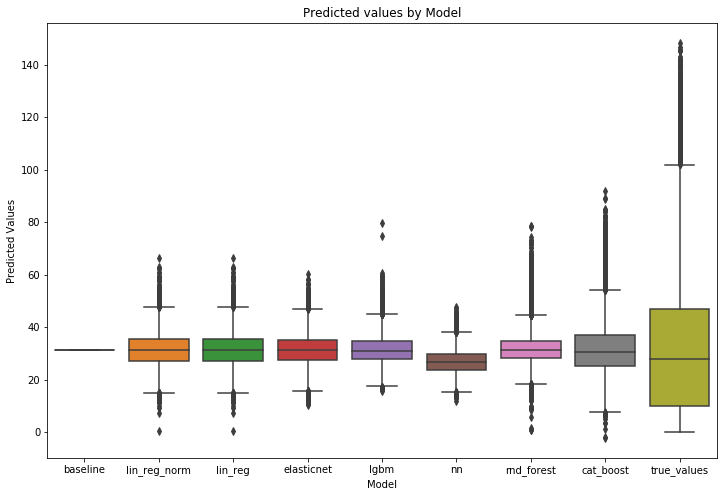

In [163]:
plt.figure(figsize=(12,8))
ax = sns.boxplot(data=results)
ax.set_title('Predicted values by Model')
ax.set_xlabel('Model')
ax.set_ylabel('Predicted Values')
plt.show();

#### Choosing best model (According to Spearman correlation):

In [164]:
df=pd.DataFrame(columns=["model","spearman"])
for col in results.columns:
    df=df.append({"model":col, "spearman":np.corrcoef(y_test, results[col])[0,1]}, ignore_index=True)
df = df.sort_values('spearman')

In [175]:

df_rmse=pd.DataFrame(columns=["model","rmse"])
for col in results.columns:
    df_rmse=df_rmse.append({"model":col, "rmse":np.sqrt(mean_squared_error(y_test, results[col]))}, ignore_index=True)
df_rmse = df_rmse.sort_values('rmse')

#### (Add y_test - True values)

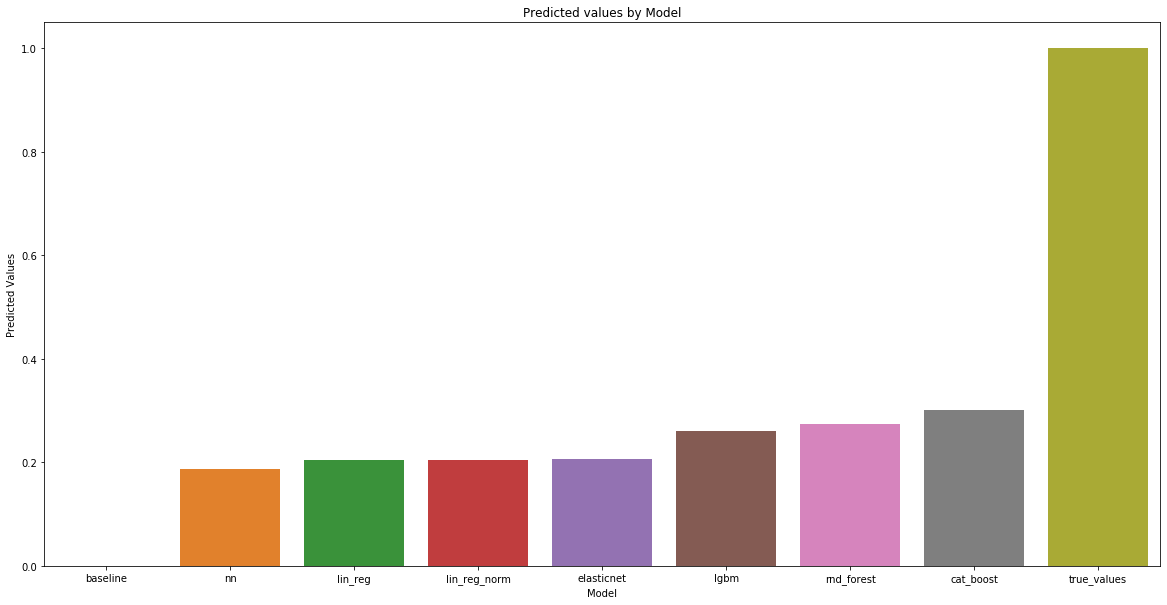

In [179]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x="model", y="spearman", data=df)
ax.set_title('Predicted values by Model')
ax.set_xlabel('Model')
ax.set_ylabel('Predicted Values')
plt.show();

Chosen model is *** with *** value

#### True values vs. Predicted values

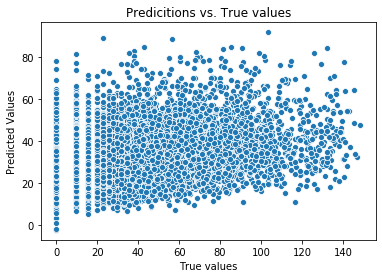

In [178]:


ax = sns.scatterplot(x=y_test, y=cat_preds)
ax.set_title('Predicitions vs. True values')
ax.set_xlabel('True values')
ax.set_ylabel('Predicted Values')
plt.show();

#### Model interpretation - Feature impact on target variable

In [170]:
shap_explainer = shap.TreeExplainer(rf_best.estimators_[1])
shap_values = shap_explainer.shap_values(X_test[:3000])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


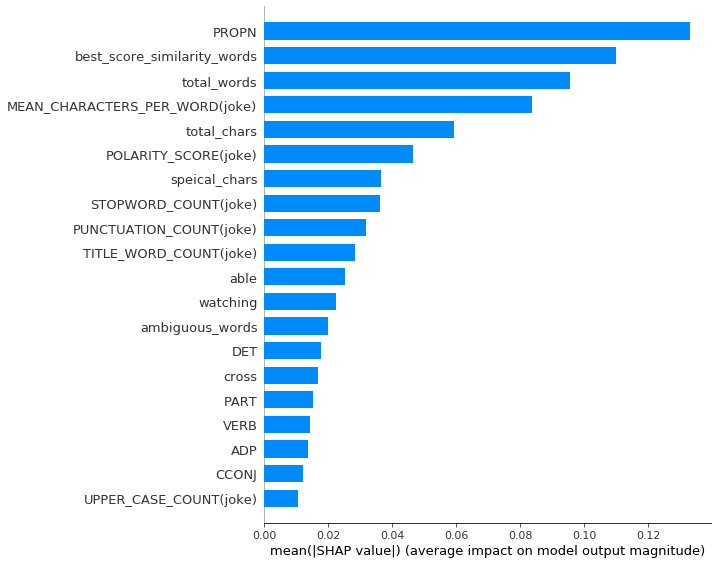

In [38]:
shap.summary_plot(shap_values,X_train,plot_type='bar')